### 導入套件

cv2：opencv 是計算機視覺，應用於照片識別人臉標示人名


In [7]:
import assignment2.src.constant
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import constant  #自訂常量

In [9]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D

### 處理 Dataset

##### 引入 Dataset

將貓狗`img`轉換成`array`放入`data`中，`label`放入 0、1 分別表示貓和狗  
因為訓練用圖片大小不一，所以 Resize 成同一大小

- 機器學習圖片設為灰階的原因：
  - 減少計算量
  - 很多演算法對於顏色的依賴性不強
  - 識別物體關鍵是梯度，彩色的圖片可能會引響梯度的萃取(ex:光照、陰影等)
  - RGB 不能反映圖像的形態特徵(只是在光學的原理上進行顏色調配)，**顏色所能帶來的信息不多**

> 這裡使用 PIL 讀取圖片會報錯 `UnidentifiedImageError`  
> 發現是 Microsoft 給的資料庫中，PetImages/Cat 和 Dog 資料夾分別有一張 0kB 的假照片  
> 把那兩張照片移除，PIL 便可正常讀取  
> 但這邊還是為了方便，使用 cv2 讀取


In [3]:
import os
import glob
import numpy as np
from PIL import Image

train_dir = os.path.join(constant.DATASET_DIR, 'train')
dict_lables = {"cat": 0, "dog": 1}
size = (64, 64)
data = []
label = []


def create_test_data(path):
    for p in os.listdir(path):
        category = p.split(".")[0]
        category = dict_lables[category]
        img = load_img(os.path.join(path, p), color_mode="grayscale")  # 圖片灰階
        img = img.resize(size, Image.BILINEAR)
        x = img_to_array(img)
        data.append(x)
        label.append(category)


print(train_dir)
create_test_data(train_dir)
data = np.array(data)
label = np.array(label)


C:\Users\USER\Desktop\Master_0\ESC_LAB\assignment2\dataset\train


TypeError: Cannot handle this data type: (1, 1, 1), <f4

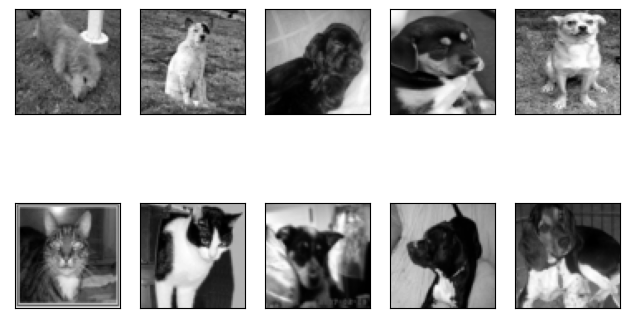

In [39]:
# 顯示部分處理後的圖片
import random

fig = plt.figure()

for i in range(1, 11):
    plt.subplot(2, 5, i)
    im = array_to_img(data[random.randint(0, data.shape[0])])
    plt.imshow(im, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

##### 處理圖片

重新定義尺寸和將處理好的陣列儲存，方便下次不用再次處理資料  
資料改變排列順序


In [50]:
import random

data = np.array(data).reshape(-1, 64, 64, 1)  #轉data變成只有一列，但是行數未知[[], []...]]
label = np.array(label)
print("data.shape: {}\nlabel.shape: {}".format(data.shape, label.shape))
print(type(data), type(label))

# Normalize Data(資料正規化)
# 我們在進行影像辨識時，我們在進行圖像預處理時，也會習慣將像素值縮放到[0,1]之間(即除以255)
data = data / 255.0

#資料重新排序(洗牌)
temp = list(zip(data, label))
random.shuffle(temp)
data, label = zip(*temp)
# 轉換回去array type
data = np.array(data)
label = np.array(label)

# print(data)
# print(label)

# Save array in .npy file in data folder
np.save(os.path.join(constant.DATA_DIR, 'preprocessed_data'), data)
np.save(os.path.join(constant.DATA_DIR, 'preprocessed_label'), label)
print('save preprocessed data done.')

data.shape: (22675, 64, 64, 1)
label.shape: (22675,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
save preprocessed data done.


#### 切割資料集

切割為訓練集、驗證集和測試集(8:1:1)
train_test_split() 所接受的變數其實非常單純，基本上為 3 項：『原始的資料』、『Seed』、『比例』  
這邊設定訓練資料80%，測試資料20%  
* 原始的資料：就如同上方的 data 一般，是我們打算切成 Training data 以及 Test data 的原始資料
* Seed： 亂數種子，可以固定我們切割資料的結果
* 比例：可以設定 train_size 或 test_size，只要設定一邊即可，範圍在 [0-1] 之間

In [52]:
import os
from sklearn.model_selection import train_test_split

#load .npy file
data = np.load(os.path.join(constant.DATA_DIR, "preprocessed_data.npy"))
label = np.load(os.path.join(constant.DATA_DIR, "preprocessed_label.npy"))

#切割訓練資料集和測試資料集8:2
train_data, test_data, train_label, test_label = train_test_split(
    data, label, test_size=0.2, random_state=42)

#從測試資料集切割1:1給驗證集
validation_data, test_data, validation_label, test_label = train_test_split(
    test_data, test_label, test_size=0.5, random_state=42)

print("train data shape: {}\ntrain data label shape: {}".format(train_data.shape, train_label.shape))
print("validation data shape: {}\nvalidation data label shape: {}".format(validation_data.shape, validation_label.shape))
print("test data shape: {}\ntest data label shape: {}".format(test_data.shape, test_label.shape))

train data shape: (18140, 64, 64, 1)
train data label shape: (18140,)
validation data shape: (2267, 64, 64, 1)
validation data label shape: (2267,)
test data shape: (2268, 64, 64, 1)
test data label shape: (2268,)


### CNN 模型的建立

1. 要先建構神經網路架構，所以要靠 Sequential()來定義


In [53]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=data.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
# Add a softmax layer with 10 output units:
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                802880    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

### Run CNN

> 在 Run tensorflow 的 code 時，一直出現 kernel die 的報錯
> 看[官方集合問題](https://github.com/microsoft/vscode-jupyter/wiki/Kernel-crashes)後  
> [解答](https://github.com/microsoft/vscode-jupyter/wiki/Kernel-crashes-when-using-tensorflow)
> 重新安裝 tensorflow，就解決問題了

> 要再次訓練的時候發現kernel又掛掉，是[cuDNN版本的問題](https://blog.csdn.net/qq_45071353/article/details/124091856)不相容導致的，改成`cuDNN v8.0.5`就可以了


In [54]:
train_history = model.fit(train_data, train_label, epochs=10, batch_size=32,
                          validation_data=(validation_data, validation_label), validation_freq=1)

Epoch 1/10
567/567 [==============================] - 20s 26ms/step - loss: 0.6933 - accuracy: 0.5020 - val_loss: 0.6934 - val_accuracy: 0.4826
Epoch 2/10
567/567 [==============================] - 18s 31ms/step - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6935 - val_accuracy: 0.4826
Epoch 3/10
567/567 [==============================] - 30s 52ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6935 - val_accuracy: 0.4826
Epoch 4/10
567/567 [==============================] - 30s 52ms/step - loss: 0.6931 - accuracy: 0.5051 - val_loss: 0.6933 - val_accuracy: 0.4826
Epoch 5/10
567/567 [==============================] - 34s 61ms/step - loss: 0.6931 - accuracy: 0.5052 - val_loss: 0.6934 - val_accuracy: 0.4826
Epoch 6/10
567/567 [==============================] - 33s 58ms/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6936 - val_accuracy: 0.4826
Epoch 7/10
567/567 [==============================] - 42s 74ms/step - loss: 0.6931 - accuracy: 0.5048 - val_loss: 0.6936 - val_accuracy:

### 訓練好的模型和資料儲存


In [55]:
import os

os.chdir(constant.OUTPUT_DIR)  # To output folder
history_data = pd.DataFrame.from_dict(train_history.history, orient='index').T
history_data.to_excel('loss_accuracy_data.xlsx', sheet_name='sheet1', index=False)
history_data.to_pickle('loss_accuracy_data.pkl')
model.save("catdog_model.h5")
print(history_data, '\n\n')


       loss  accuracy  val_loss  val_accuracy
0  0.693198  0.500937  0.693429      0.482576
1  0.693149  0.503694  0.693485      0.482576
2  0.693167  0.501047  0.693489      0.482576
3  0.693154  0.503694  0.693301      0.482576
4  0.693157  0.503694  0.693415      0.482576
5  0.693150  0.503694  0.693596      0.482576
6  0.693157  0.503694  0.693589      0.482576
7  0.693146  0.503694  0.693287      0.482576
8  0.693161  0.503694  0.693315      0.482576
9  0.693159  0.501709  0.693519      0.482576 




### 繪製圖表

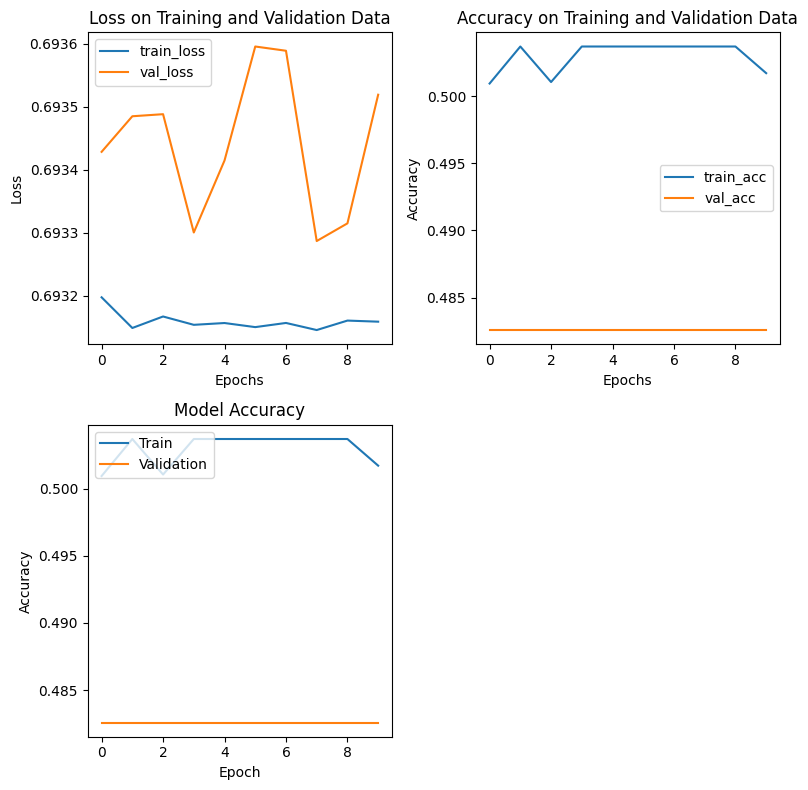

In [56]:
import matplotlib.pyplot as plt
import pickle
import os

with open(os.path.join(constant.OUTPUT_DIR, 'loss_accuracy_data.pkl'), 'rb') as file:
    history_data = pickle.load(file)
    history_data = history_data.to_dict(orient='list')


def training_plot(_history):
    loss = _history['loss']
    val_loss = _history['val_loss']
    acc = _history['accuracy']
    val_acc = _history['val_accuracy']

    #製作圖表
    fig = plt.figure(figsize=(8, 8))  #建立畫板(8*4英吋)
    # 描繪損失函數
    fig1 = fig.add_subplot(221)  # 一行兩列的第一個
    fig1.plot(loss, label='train_loss')
    fig1.plot(val_loss, label='val_loss')
    fig1.set_xlabel('Epochs')  #設定x軸
    fig1.set_ylabel('Loss')  #設定y軸
    fig1.set_title('Loss on Training and Validation Data')
    fig1.legend()  #給圖像加圖例
    # plt.show()

    # # subplot acc
    fig2 = fig.add_subplot(222)
    fig2.plot(acc, label='train_acc')
    fig2.plot(val_acc, label='val_acc')
    fig2.set_xlabel('Epochs')
    fig2.set_ylabel('Accuracy')
    fig2.set_title('Accuracy on Training and Validation Data')
    fig2.legend()  #給圖像加圖例

    plt.subplot(223)
    plt.plot(_history['accuracy'])
    plt.plot(_history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')  #loc設置圖例位置

    plt.tight_layout()  #自動保持子圖的正確間距


training_plot(history_data)

### 訓練 History 和資料讀檔


In [ ]:
import pandas as pd
import os

os.chdir('C:/Users/USER/Desktop/Master_0/ESC_LAB/assignment2/output')


# 載入pkl檔案
def read_history_pkl():
    train_history = pd.read_pickle("loss_accuracy_data.pkl")
    print(train_history)


read_history_pkl()
# 載入訓練好的模型
model = load_model('catdog_model.h5')
# score = model.evaluate(data, label, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])
model.summary()


### 測試模型


In [ ]:
test_dir = os.path.join(os.getcwd(), "dataset", "test1")
test_data = []
id_line = []


def create_test_data(path):
    for f in os.listdir(test_dir):
        id_line.append(f.split(".")[0])
        img = cv2.imread(os.path.join(test_dir, f), cv2.IMREAD_GRAYSCALE)
        img_arr = cv2.resize(img, dsize=(80, 80))
        test_data.append(img_arr)


create_test_data(test_dir)
test_data = np.array(test_data).reshape(-1, 80, 80, 1)
test_data = test_data / 255.0

prediction = model.predict(test_data)

In [ ]:
predicted_val = [int(round(p[0])) for p in prediction]
submission_df = pd.DataFrame({'id': id_line, 'label': predicted_val})
submission_df.to_excel("submission.xlsx", sheet_name='sheet1', index=False)
